**Começamos instalando as bibliotecas que vamos utilizar**

In [ ]:
pip install fsspec

In [ ]:
pip install gcsfs

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
pip install pyspark

In [ ]:
pip install pandas

In [ ]:
pip install pandera

**Importando as Bibliotecas com apelido para facilitar a sua utilização**

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F 
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import sum
from pyspark.sql.window import Window

In [ ]:
import pandas as pd
import pandera as pa
import numpy as np
import collections
from operator import itemgetter

**Estrutura do Pyspark**

In [ ]:
spark = (
    SparkSession.builder
      .master('local')
      .appName('dataframe_withcolumn')
      .config('spark.ui.port', '4050')
      .getOrCreate()
)

**Lendo o Arquivo .json a ser tratado**

In [ ]:
amazon_df = pd.read_json("gs://projeto_amazon_netflix/Amazon/entrada/amazon_prime_titles.json")
amazon_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...
...,...,...,...,...,...,...,...,...,...,...,...,...
9663,s9664,Movie,Pride Of The Bowery,Joseph H. Lewis,"Leo Gorcey, Bobby Jordan",,,1940,7+,60 min,Comedy,New York City street principles get an East Si...
9664,s9665,TV Show,Planet Patrol,,"DICK VOSBURGH, RONNIE STEVENS, LIBBY MORRIS, M...",,,2018,13+,4 Seasons,TV Shows,"This is Earth, 2100AD - and these are the adve..."
9665,s9666,Movie,Outpost,Steve Barker,"Ray Stevenson, Julian Wadham, Richard Brake, M...",,,2008,R,90 min,Action,"In war-torn Eastern Europe, a world-weary grou..."
9666,s9667,TV Show,Maradona: Blessed Dream,,"Esteban Recagno, Ezequiel Stremiz, Luciano Vit...",,,2021,TV-MA,1 Season,"Drama, Sports","The series tells the story of Diego Maradona, ..."


In [ ]:
amazon_df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...
5,s6,Movie,Living With Dinosaurs,Paul Weiland,"Gregory Chisholm, Juliet Stevenson, Brian Hens...",United Kingdom,"March 30, 2021",1989,,52 min,"Fantasy, Kids",The story unfolds in a an English seaside town...
6,s7,Movie,Hired Gun,Fran Strine,"Alice Cooper, Liberty DeVitto, Ray Parker Jr.,...",United States,"March 30, 2021",2017,,98 min,"Documentary, Special Interest","They are the ""First Call, A-list"" musicians, j..."
7,s8,Movie,Grease Live!,"Thomas Kail, Alex Rudzinski","Julianne Hough, Aaron Tveit, Vanessa Hudgens, ...",United States,"March 30, 2021",2016,,131 min,Comedy,"This honest, uncompromising comedy chronicles ..."
8,s9,Movie,Global Meltdown,Daniel Gilboy,"Michael Paré, Leanne Khol Young, Patrick J. Ma...",Canada,"March 30, 2021",2017,,87 min,"Action, Science Fiction, Suspense",A helicopter pilot and an environmental scient...
9,s10,Movie,David's Mother,Robert Allan Ackerman,"Kirstie Alley, Sam Waterston, Stockard Channing",United States,"April 1, 2021",1994,,92 min,Drama,Sally Goodson is a devoted mother to her autis...


**Fazendo um BACKUP do dataframe para evitar possíveis perdas de dados**

In [ ]:
dfbackup = amazon_df.copy()

**Renomeando o SCHEMA para o PT-BR (atendendo ao requisito tradução) Porém evitamos usar maiúsculas,acentos e outros caracteres, para que o código possa ser lido em diferentes ferramentas sem causar erros.**

In [ ]:
amazon_df.rename(columns={'show_id':'id','type':'tipo','title':'titulo','director':'diretor','cast':'elenco','country':'pais','date_added':'data_adicionado','release_year':'ano_lancamento','rating':'classificacao','duration':'duracao','listed_in':'genero','description':'descricao'}, inplace=True)

**Mudando o formato data**

In [ ]:
amazon_df['data_adicionado'] = pd.to_datetime(amazon_df.data_adicionado)

**Fizemos aqui uma breve análise para já identificar algumas inconsistências**



In [ ]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               9668 non-null   object        
 1   tipo             9668 non-null   object        
 2   titulo           9668 non-null   object        
 3   diretor          9668 non-null   object        
 4   elenco           9668 non-null   object        
 5   pais             9668 non-null   object        
 6   data_adicionado  155 non-null    datetime64[ns]
 7   ano_lancamento   9668 non-null   int64         
 8   classificacao    9668 non-null   object        
 9   duracao          9668 non-null   object        
 10  genero           9668 non-null   object        
 11  descricao        9668 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 906.5+ KB


In [ ]:
df = amazon_df[['data_adicionado']].groupby(amazon_df.classificacao)
df.head(10)

,data_adicionado
0,2021-03-30
1,2021-03-30
2,2021-03-30
3,2021-03-30
4,2021-03-30
...,...
5377,NaT
5734,NaT
6012,NaT
6408,NaT


In [ ]:
amazon_df.isnull()

,id,tipo,titulo,diretor,elenco,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero,descricao
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9663,False,False,False,False,False,False,True,False,False,False,False,False
9664,False,False,False,False,False,False,True,False,False,False,False,False
9665,False,False,False,False,False,False,True,False,False,False,False,False
9666,False,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
amazon_df.shape

(9668, 12)

In [ ]:
na_df = pd.DataFrame(amazon_df.isna().sum(), columns=['Contagem de NaN'])
na_df[ na_df['Contagem de NaN']>0].sort_values('Contagem de NaN', ascending=False)

,Contagem de NaN
data_adicionado,9513


In [ ]:
amazon_df.describe(include="all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,id,tipo,titulo,diretor,elenco,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero,descricao
count,9668,9668,9668,9668,9668,9668,155,9668.000000,9668,9668,9668,9668.0
unique,9668,2,9667,5774,7927,87,84,NaN,25,219,518,9414.0
top,s9195,Movie,Mixed Up,,,,2021-03-30 00:00:00,NaN,13+,1 Season,Drama,1.0
freq,1,7814,2,2082,1233,8996,14,NaN,2117,1342,986,15.0
first,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-30 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-10 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.341849,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.922482,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1920.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,NaN,NaN,NaN,NaN


**Tratamos aqui alguns espaços em branco (sem dados declarados) Optamos aqui por não dropar estas linhas por entender que talvez se perdessem dados de filmes e programas muito antigos, e que podem fazer parde de um histórico importante.**

In [ ]:
amazon_df.pais.fillna("Nao Declarado", inplace=True)
amazon_df.diretor.fillna("Nao Declarado", inplace=True)
amazon_df.elenco.fillna("Nao Declarado", inplace=True)
amazon_df.classificacao.fillna("Nao avaliado", inplace=True)

In [ ]:
amazon_df.loc[amazon_df.classificacao == "", ['classificacao']]="Nao avaliado"
amazon_df.loc[amazon_df.diretor == "",['diretor']]="Nao Declarado"
amazon_df.loc[amazon_df.elenco == "",['elenco']]="Nao Declarado"

In [ ]:
pd.unique(amazon_df['tipo'])

array(['Movie', 'TV Show'], dtype=object)

In [ ]:
pd.unique(amazon_df['pais'])

array(['Canada', 'India', 'United States', 'United Kingdom', 'France',
       'Spain', '', 'Italy', 'United Kingdom, France',
       'United States, Italy', 'United States, India',
       'United Kingdom, United States',
       'United States, United Kingdom, Germany', 'Japan',
       'China, United States, United Kingdom',
       'Denmark, United Kingdom, Czech Republic, Netherlands',
       'United States, Ireland', 'United States, United Kingdom, Canada',
       'United Kingdom, United States, India', 'United Kingdom, India',
       'United States, China', 'Canada, United States',
       'United States, Thailand', 'Brazil, United States, India',
       'Switzerland, India', 'United Kingdom, Canada, United States',
       'Germany', 'Australia', 'Belgium',
       'Chile, Argentina, United States', 'Mexico',
       'Denmark, Sweden, United States', 'Netherlands',
       'United States, United Kingdom', 'New Zealand',
       'United States, Portugal', 'United States, France',
       'C

In [ ]:
amazon_df.sort_values(['tipo','pais','ano_lancamento'],ascending=[False,False,True])

,id,tipo,titulo,diretor,elenco,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero,descricao
546,s547,TV Show,The Man In the High Castle,Nao Declarado,"Alexa Davalos, Joel de la Fuente, Jason O’Mara...","United States, United Kingdom, Canada",NaT,2019,18+,4 Seasons,"Action, Drama, Historical","In the climactic final season, America will wi..."
3092,s3093,TV Show,Betas,Nao Declarado,"Joe Dinicol, Karan Soni, Jon Daly, Charlie Saxton",United States,NaT,2014,TV-MA,1 Season,Comedy,"Trey and his guys have an app, and a plan - no..."
3308,s3309,TV Show,Alpha House,Nao Declarado,"John Goodman, Mark Consuelos, Matt Malloy, Cla...",United States,NaT,2014,18+,2 Seasons,"Comedy, Drama",An Amazon Original series: They work in the Se...
589,s590,TV Show,The Kicks,Nao Declarado,"Sixx Orange, Isabella Acres, E'myri Crutchfiel...",United States,NaT,2016,ALL,1 Season,Kids,Devin Burke and her family have moved cross-co...
2305,s2306,TV Show,Gortimer Gibbon's Life on Normal Street,Nao Declarado,"Sloane Morgan Siegel, Ashley Boettcher, Drew J...",United States,NaT,2016,7+,3 Seasons,Kids,"As the series comes to a close, Gortimer, Mel ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
9628,s9629,Movie,Thalaivii (Malayalam),A.L. Vijay,"Kangana Ranaut, Arvind Swamy, Nassar",,NaT,2021,ALL,151 min,Drama,Thalaivi is the dramatic story of a woman who ...
9629,s9630,Movie,Thalaivii (Kannada),A.L. Vijay,"Kangana Ranaut, Arvind Swamy, Nassar",,NaT,2021,ALL,151 min,Drama,Thalaivi is the dramatic story of a woman who ...
9656,s9657,Movie,Anaganaga Oka Nenu,Vamshi P,"Vijay, Sweta chaudhary, NNR CHOWDARY, Hariya",,NaT,2021,18+,135 min,"Action, Drama, Suspense",Peter(hero) Who went to the forest to find a c...
9660,s9661,Movie,The Man in the Hat,"John-Paul Davidson, Stephen Warbeck","Ciaran Hinds, Stephen Dillane, Maïwenn",,NaT,2021,13+,96 min,Comedy,The Man in the Hat journeys through France in ...


**EXCLUÍMOS DADOS QUE NÃO IREMOS UTILIZAR**

In [ ]:
amazon_df.drop(['descricao'], axis=1, inplace=True)
amazon_df.drop(['elenco'], axis=1, inplace=True)
amazon_df.drop(['diretor'], axis=1, inplace=True)

**TRADUÇÃO DOS PAÍSES**

In [ ]:
amazon_df.loc[amazon_df.pais == "Italy",['pais']] = 'Italia'
amazon_df.loc[amazon_df.pais == "",['pais']] = 'Nao Declarado'
amazon_df.loc[amazon_df.pais == "United Kingdom",['pais']] = 'Reino Unido'
amazon_df.loc[amazon_df.pais == "United States",['pais']] = 'Estados Unidos'
amazon_df.loc[amazon_df.tipo == "Movie", ['tipo']]= "Filme"
amazon_df.loc[amazon_df.tipo == "TV Show", ['tipo']]= "Serie"
amazon_df.loc[amazon_df.pais == 'Spain',['pais']] = 'Espanha'
amazon_df.loc[amazon_df.pais == "Switzerland",['pais']] = 'Suica'
amazon_df.loc[amazon_df.pais == 'South Africa',['pais']] = 'Africa do Sul'
amazon_df.loc[amazon_df.pais == 'Germany',['pais']] = 'Alemanha'
amazon_df.loc[amazon_df.pais == "Malaysia",['pais']] = 'Malasia'
amazon_df.loc[amazon_df.pais == "New Zealand",['pais']] = 'Nova Zelandia'
amazon_df.loc[amazon_df.pais == "Hungary",['pais']] = 'Hungria'
amazon_df.loc[amazon_df.pais == "Belgium",['pais']] = 'Belgica'
amazon_df.loc[amazon_df.pais == "Poland",['pais']] = 'Polonia'
amazon_df.loc[amazon_df.pais == "Japan",['pais']] = 'Japao'
amazon_df.loc[amazon_df.pais == "France",['pais']] = 'Franca'
amazon_df.loc[amazon_df.pais == "Netherlands",['pais']] = 'Holanda'
amazon_df.loc[amazon_df.pais == "Czech Republic",['pais']] = 'Republica Checa'
amazon_df.loc[amazon_df.pais == "Denmark",['pais']] = 'Dinamarca' 
amazon_df.loc[amazon_df.pais == "Ireland",['pais']] = 'Irlanda' 
amazon_df.loc[amazon_df.pais == "Sweden",['pais']] = 'Suecia' 
amazon_df.loc[amazon_df.pais == "Ireland",['pais']] = 'Irlanda' 
amazon_df.loc[amazon_df.pais == "Egypt",['pais']] = 'Egito' 
amazon_df.loc[amazon_df.pais == "Ireland",['pais']] = 'Irlanda' 
amazon_df.loc[amazon_df.pais == 'United States, United Kingdom, Kazakhstan',['pais']] = 'Estados Unidos, Reino Unido,Cazaquistao '
amazon_df.loc[amazon_df.pais == "United States, United Kingdom, Germany",['pais']] = 'Estados Unidos, Reino Unido, Alemanha'
amazon_df.loc[amazon_df.pais == 'United States, United Kingdom, Canada',['pais']] = 'Estados Unidos, Reino Unido, Canada'
amazon_df.loc[amazon_df.pais == 'United States, United Kingdom',['pais']] = 'Estados Unidos, Reino Unido'
amazon_df.loc[amazon_df.pais == "United States, United Arab Emirates",['pais']] = 'Estados Unidos, Emirados Arabes Unidos'
amazon_df.loc[amazon_df.pais == "United States, Thailand",['pais']] = 'Estados Unidos, Tailandia'
amazon_df.loc[amazon_df.pais == "United States, Switzerland",['pais']] = 'Estados Unidos, Suica'
amazon_df.loc[amazon_df.pais == "United States, Sweden, Norway",['pais']] = 'Estados Unidos, Suecia, Noruega'
amazon_df.loc[amazon_df.pais == "United States, Portugal",['pais']] = 'Estados Unidos, Portugal'
amazon_df.loc[amazon_df.pais == "United States, Mexico",['pais']] = 'Estados Unidos, Mexico'
amazon_df.loc[amazon_df.pais == "United States, Japan, Singapore, South Korea",['pais']] = 'Estados Unidos, Japao, Singapura, Coreia do Sul'
amazon_df.loc[amazon_df.pais == "United States, Japan",['pais']] = 'Estados Unidos, Japao'
amazon_df.loc[amazon_df.pais == "United States, Italy",['pais']] = 'Estados Unidos, Italia'
amazon_df.loc[amazon_df.pais == "United States, Ireland",['pais']] = 'Estados Unidos, Irlanda' 
amazon_df.loc[amazon_df.pais == "United States, India",['pais']] = 'Estados Unidos, India' 
amazon_df.loc[amazon_df.pais == "United States, Germany, Japan, United Kingdom, Hong Kong",['pais']] = 'Estados Unidos, Alemanha, Japao, Reino Unido, Hong Kong' 
amazon_df.loc[amazon_df.pais == "United States, Germany, Italy",['pais']] = 'Estados Unidos, Alemanha, Italia' 
amazon_df.loc[amazon_df.pais == "United States, Germany, Brazil, Italy",['pais']] = 'Estados Unidos, Alemanha, Brasil, Italia' 
amazon_df.loc[amazon_df.pais == "United States, Germany",['pais']] = 'Estados Unidos, Alemanha' 
amazon_df.loc[amazon_df.pais == "United States, France, Denmark",['pais']] = 'Estados Unidos, Franca, Dinamarca' 
amazon_df.loc[amazon_df.pais == "United States, France",['pais']] = 'Estados Unidos, Franca' 
amazon_df.loc[amazon_df.pais == "United States, China",['pais']] = 'Estados Unidos, China' 
amazon_df.loc[amazon_df.pais == "United States, Canada",['pais']] = 'Estados Unidos, Canada' 
amazon_df.loc[amazon_df.pais == "United States, Belgium, Denmark, France",['pais']] = 'Estados Unidos, Belgica, Dinamarca, Franca' 
amazon_df.loc[amazon_df.pais == "United States, Austria",['pais']] = 'Estados Unidos, Austria' 
amazon_df.loc[amazon_df.pais == "United Kingdom, United States, India",['pais']] = 'Reino Unido, Estados Unidos, India' 
amazon_df.loc[amazon_df.pais == "United Kingdom, United States",['pais']] = 'Reino Unido, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "United Kingdom, Spain",['pais']] = 'Reino Unido, Espanha' 
amazon_df.loc[amazon_df.pais == "United Kingdom, India",['pais']] = 'Reino Unido, India' 
amazon_df.loc[amazon_df.pais == "United Kingdom, Hungary, United States",['pais']] = 'Reino Unido, Hungria, Estados Unidos'
amazon_df.loc[amazon_df.pais == "United Kingdom, France, United States",['pais']] = 'Reino Unido, Franca, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "United Kingdom, France",['pais']] = 'Reino Unido, Franca' 
amazon_df.loc[amazon_df.pais == "United Kingdom, Canada, United States",['pais']] = 'Reino Unido, Canada, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "Switzerland, India",['pais']] = 'Suica, India' 
amazon_df.loc[amazon_df.pais == "Spain, United Kingdom, Italy",['pais']] = 'Espanha, Reino Unido, Italia' 
amazon_df.loc[amazon_df.pais == "Poland, United States",['pais']] = 'Polonia, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "Kosovo, Netherlands",['pais']] = 'Kosovo, Holanda' 
amazon_df.loc[amazon_df.pais == "Kosovo, Albania, United States, Georgia",['pais']] = 'Kosovo, Albania, Estados Unidos, Georgia' 
amazon_df.loc[amazon_df.pais == "Japan, France",['pais']] = 'Japao, Franca' 
amazon_df.loc[amazon_df.pais == "Italy, Spain",['pais']] = 'Italia, Espanha' 
amazon_df.loc[amazon_df.pais == "Italy, Canada",['pais']] = 'Italia, Canada' 
amazon_df.loc[amazon_df.pais == "Ireland, Belgium, France, Luxembourg, United Kingdom",['pais']] = 'Irlanda, Belgica, Franca, Luxemburgo, Reino Unido' 
amazon_df.loc[amazon_df.pais == "Iran, France",['pais']] = 'Ira, Franca' 
amazon_df.loc[amazon_df.pais == "India, United States, United Kingdom, Canada, China",['pais']] = 'India, Estados Unidos, Reino Unido, Canada, China' 
amazon_df.loc[amazon_df.pais == "India, United States",['pais']] = 'India, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "India, Sweden",['pais']] = 'India, Suecia' 
amazon_df.loc[amazon_df.pais == "India, South Africa, Brazil",['pais']] = 'India, Africa do Sul, Brasil' 
amazon_df.loc[amazon_df.pais == "India, Denmark",['pais']] = 'India, Dinamarca' 
amazon_df.loc[amazon_df.pais == "Germany, Canada, United States, France, United Kingdom",['pais']] = 'Alemanha, Canada, Estados Unidos, Franca, Reino Unido' 
amazon_df.loc[amazon_df.pais == "Germany, Austria, United States",['pais']] = 'Alemanha, Austria, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "France, United States",['pais']] = 'Franca, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "France, China, Belgium, Monaco",['pais']] = 'Franca, China, Belgica, Monaco' 
amazon_df.loc[amazon_df.pais == "France, Belgium",['pais']] = 'Franca, Belgica' 
amazon_df.loc[amazon_df.pais == "Denmark, United Kingdom, Czech Republic, Netherlands",['pais']] = 'Dinamarca, Reino Unido, Republica Checa,Holanda' 
amazon_df.loc[amazon_df.pais == "Denmark, Sweden, United States",['pais']] = 'Dinamarca, Suecia, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "Denmark, France",['pais']] = 'Dinamarca, Franca' 
amazon_df.loc[amazon_df.pais == "Czech Republic, Germany",['pais']] = 'Republica Checa, Almemanha' 
amazon_df.loc[amazon_df.pais == "China, United States, United Kingdom",['pais']] = 'China, Estados Unidos, Reino Unido' 
amazon_df.loc[amazon_df.pais == "Chile, Argentina, United States",['pais']] = 'Chile, Argentina, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "Canada, United States, Brazil",['pais']] = 'Canada, Estados Unidos, Brasil' 
amazon_df.loc[amazon_df.pais == "Canada, United States",['pais']] = 'Canada, Estados Unidos' 
amazon_df.loc[amazon_df.pais == "Canada, Germany",['pais']] = 'Canada, Alemanha' 
amazon_df.loc[amazon_df.pais == "Brazil, United States, India",['pais']] = 'Brasil, Estados Unidos, India' 
amazon_df.loc[amazon_df.pais == "Brazil",['pais']] = 'Brasil' 
amazon_df.loc[amazon_df.pais == "Australia, United States, Germany",['pais']] = 'Australia, Estados Unidos, Alemanha' 
amazon_df.loc[amazon_df.pais == "Australia, Colombia, United Kingdom",['pais']] = 'Australia, Colombia, Reino Unido' 
amazon_df.loc[amazon_df.pais == "Afghanistan, France",['pais']] = 'Afeganistao, Franca' 

In [ ]:
pd.unique(amazon_df['pais'])

array(['Canada', 'India', 'Estados Unidos', 'Reino Unido', 'Franca',
       'Espanha', 'Nao Declarado', 'Italia', 'Reino Unido, Franca',
       'Estados Unidos, Italia', 'Estados Unidos, India',
       'Reino Unido, Estados Unidos',
       'Estados Unidos, Reino Unido, Alemanha', 'Japao',
       'China, Estados Unidos, Reino Unido',
       'Dinamarca, Reino Unido, Republica Checa,Holanda',
       'Estados Unidos, Irlanda', 'Estados Unidos, Reino Unido, Canada',
       'Reino Unido, Estados Unidos, India', 'Reino Unido, India',
       'Estados Unidos, China', 'Canada, Estados Unidos',
       'Estados Unidos, Tailandia', 'Brasil, Estados Unidos, India',
       'Suica, India', 'Reino Unido, Canada, Estados Unidos', 'Alemanha',
       'Australia', 'Belgica', 'Chile, Argentina, Estados Unidos',
       'Mexico', 'Dinamarca, Suecia, Estados Unidos', 'Holanda',
       'Estados Unidos, Reino Unido', 'Nova Zelandia',
       'Estados Unidos, Portugal', 'Estados Unidos, Franca',
       'Canada, Es

**Verificação da qtde de linhas e colunas**

In [ ]:
amazon_df.shape

(9668, 9)

**A coluna classificacao continha dados no padrão e linguagem americana (USA) Foi feita uma pesquisa de equivalencia e traduzido para o padrão e idioma PT-BR**

In [ ]:
pd.unique(amazon_df.classificacao) #antes da tradução

array(['Nao avaliado', '13+', 'Livre', '18+', 'Restrito', 'Infantil',
       '7+', 'Adultos', '16+', '14+', 16], dtype=object)

In [ ]:
#Coluna Classificação Traduzida
amazon_df.loc[amazon_df.classificacao=='UNRATED',['classificacao']]='Nao avaliado'
amazon_df.loc[amazon_df.classificacao=='NOT_RATE',['classificacao']]='Nao avaliado'
amazon_df.loc[amazon_df.classificacao=='16',['classificacao']]='16+'
amazon_df.loc[amazon_df.classificacao=='G',['classificacao']]='Livre'
amazon_df.loc[amazon_df.classificacao=='E',['classificacao']]='Livre'
amazon_df.loc[amazon_df.classificacao=='R',['classificacao']]='Restrito'
amazon_df.loc[amazon_df.classificacao=='AO',['classificacao']]='Adultos'
amazon_df.loc[amazon_df.classificacao=='M',['classificacao']]='16+'
amazon_df.loc[amazon_df.classificacao=='ALL_AGES',['classificacao']]='Livre'
amazon_df.loc[amazon_df.classificacao=='AGES_18_',['classificacao']]='18+'
amazon_df.loc[amazon_df.classificacao=='AGES_16_',['classificacao']]='16+'
amazon_df.loc[amazon_df.classificacao=='NC-17',['classificacao']]='Adultos'
amazon_df.loc[amazon_df.classificacao=='ALL',['classificacao']]='Livre'
amazon_df.loc[amazon_df.classificacao=='NR',['classificacao']]='Adultos'
amazon_df.loc[amazon_df.classificacao=='PG',['classificacao']]='13+'
amazon_df.loc[amazon_df.classificacao=='NR',['classificacao']]='Adultos'
amazon_df.loc[amazon_df.classificacao=='PG',['classificacao']]='13+'
amazon_df.loc[amazon_df.classificacao=='TV-Y7',['classificacao']]='7+'
amazon_df.loc[amazon_df.classificacao=='TV-MA',['classificacao']]='Adultos'
amazon_df.loc[amazon_df.classificacao=='TV-14',['classificacao']]='14+'
amazon_df.loc[amazon_df.classificacao=='TV-G',['classificacao']]='Livre'
amazon_df.loc[amazon_df.classificacao=='TV-NR',['classificacao']]='Adultos'
amazon_df.loc[amazon_df.classificacao=='TV-Y',['classificacao']]='Infantil'
amazon_df.loc[amazon_df.classificacao=='TV-PG',['classificacao']]='7+'
amazon_df.loc[amazon_df.classificacao=='PG-13',['classificacao']]='13+'


In [ ]:
pd.unique(amazon_df.classificacao) #depois da tradução

array(['Nao avaliado', '13+', 'Livre', '18+', 'Restrito', 'Infantil',
       '7+', 'Adultos', '16+', '14+', 16], dtype=object)

**A coluna titulo dos filmes recebeu a tradução de alguns filmes. Por se tratar de uma lista extensa deve ser traduzida aos poucos porém não vimos a necessidades de concluir isso neste momento de análises**

In [ ]:
#Tradução dos dados da coluna titulo
amazon_df.loc[amazon_df.titulo=='The Grand Seduction',['titulo']]='A Grande Sedução'
amazon_df.loc[amazon_df.titulo=='Take Care Good Night',['titulo']]='Cuide da boa noite'
amazon_df.loc[amazon_df.titulo=='Secrets of Deception',['titulo']]='Segredos da Decepção'
amazon_df.loc[amazon_df.titulo=='Pink: Staying True',['titulo']]='Rosa: Mantendo-se Verdadeiro'
amazon_df.loc[amazon_df.titulo=='Monster Maker',['titulo']]='Criador de Monstros'
amazon_df.loc[amazon_df.titulo=='The Grand Seduction',['titulo']]='A Grande Sedução'
amazon_df.loc[amazon_df.titulo=='Take Care Good Night',['titulo']]='Cuide da boa noite'
amazon_df.loc[amazon_df.titulo=='Secrets of Deception',['titulo']]='Segredos da Decepção'
amazon_df.loc[amazon_df.titulo=='Pink: Staying True',['titulo']]='Rosa: Mantendo-se Verdadeiro'
amazon_df.loc[amazon_df.titulo=='Monster Maker',['titulo']]='Criador de Monstros'

amazon_df.head(20)

,id,tipo,titulo,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero
0,s1,Filme,A Grande Sedução,Canada,2021-03-30,2014,Nao avaliado,113 min,"Comedy, Drama"
1,s2,Filme,Cuide da boa noite,India,2021-03-30,2018,13+,110 min,"Drama, International"
2,s3,Filme,Segredos da Decepção,Estados Unidos,2021-03-30,2017,Nao avaliado,74 min,"Action, Drama, Suspense"
3,s4,Filme,Rosa: Mantendo-se Verdadeiro,Estados Unidos,2021-03-30,2014,Nao avaliado,69 min,Documentary
4,s5,Filme,Criador de Monstros,Reino Unido,2021-03-30,1989,Nao avaliado,45 min,"Drama, Fantasy"
5,s6,Filme,Living With Dinosaurs,Reino Unido,2021-03-30,1989,Nao avaliado,52 min,"Fantasy, Kids"
6,s7,Filme,Hired Gun,Estados Unidos,2021-03-30,2017,Nao avaliado,98 min,"Documentary, Special Interest"
7,s8,Filme,Grease Live!,Estados Unidos,2021-03-30,2016,Nao avaliado,131 min,Comedy
8,s9,Filme,Global Meltdown,Canada,2021-03-30,2017,Nao avaliado,87 min,"Action, Science Fiction, Suspense"
9,s10,Filme,David's Mother,Estados Unidos,2021-04-01,1994,Nao avaliado,92 min,Drama


**Tradução de todos os campos de Gêneros dos filmes**

In [ ]:
pd.unique(amazon_df.genero)

array(['Comedy, Drama', 'Drama, International', 'Action, Drama, Suspense',
       'Documentary', 'Drama, Fantasy', 'Fantasy, Kids',
       'Documentary, Special Interest', 'Comedy',
       'Action, Science Fiction, Suspense', 'Drama', 'Adventure, Kids',
       'Horror, Suspense', 'Documentary, Sports',
       'Horror, Science Fiction', 'Kids, Special Interest',
       'Comedy, Talk Show and Variety', 'Science Fiction', 'Kids',
       'Action, Anime, Comedy',
       'Arts, Entertainment, and Culture, Comedy, Drama', 'TV Shows',
       'Animation, Anime, Fantasy', 'Action, Adventure, Animation',
       'Anime, Kids', 'Music Videos and Concerts', 'Drama, Suspense',
       'Fitness, Special Interest',
       'Faith and Spirituality, Special Interest', 'Special Interest',
       'Fitness', 'Action, Military and War, Western',
       'Arts, Entertainment, and Culture, Comedy, Talk Show and Variety',
       'Action, Western', 'Documentary, Science Fiction',
       'Adventure, Animation, Kids'

Tradução linha a linha texto

In [ ]:
amazon_df.loc[amazon_df.genero=='Drama, Fantasy',['genero']]='Drama, Fantasia'
amazon_df.loc[amazon_df.genero=='Drama, International',['genero']]='Drama, Internacional'
amazon_df.loc[amazon_df.genero=='Documentary',['genero']]='Documentario'
amazon_df.loc[amazon_df.genero=='Comedy, Drama',['genero']]='Comedia, Drama'
amazon_df.loc[amazon_df.genero=='Action, Drama, Suspense',['genero']]='Acao, Drama, Suspense'
amazon_df.loc[amazon_df.genero=='Fantasy, Kids',['genero']]='Fantasia, Infantil'
amazon_df.loc[amazon_df.genero=='Comedy, Drama, Science Fiction',['genero']]='Comedia, Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero=='Comedy, Horror',['genero']]='Comedia, Terror'
amazon_df.loc[amazon_df.genero=='Comedy',['genero']]='Comedia'
amazon_df.loc[amazon_df.genero=='Action, Animation',['genero']]='Acao, Animacao'
amazon_df.loc[amazon_df.genero=='Comedy, Drama, Science Fiction',['genero']]='Comedia, Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero=='Adventure, Kids',['genero']]='Aventura, Infantil'
amazon_df.loc[amazon_df.genero=='Horror, Suspense',['genero']]='Terror, Suspense'
amazon_df.loc[amazon_df.genero=='Action, Animation',['genero']]='Acao, Animacao'
amazon_df.loc[amazon_df.genero=='Science Fiction, Special Interest',['genero']]='Ficcao Cientifica, Conteudo Especial'
amazon_df.loc[amazon_df.genero=='Talk Show',['genero']]='Entrevista'
amazon_df.loc[amazon_df.genero=='Action, Animation',['genero']]='Acao, Animacao'
amazon_df.loc[amazon_df.genero=='Sports',['genero']]='Esporte'
amazon_df.loc[amazon_df.genero=='Kids',['genero']]='Infantil'
amazon_df.loc[amazon_df.genero=='Entertainment',['genero']]='Entretenimento'
amazon_df.loc[amazon_df.genero=='Animation, Anime, Fantasy',['genero']]='Animacao, Anime, Fantasia'
amazon_df.loc[amazon_df.genero=='Anime, Kids',['genero']]='Anime, Infantil'
amazon_df.loc[amazon_df.genero=='Animation',['genero']]='Animacao'
amazon_df.loc[amazon_df.genero=='Variety',['genero']]='Variedade'
amazon_df.loc[amazon_df.genero=='Action, Drama',['genero']]='Acao, Drama'
amazon_df.loc[amazon_df.genero=='Sports',['genero']]='Esporte'
amazon_df.loc[amazon_df.genero=='Kids',['genero']]='Infantil'
amazon_df.loc[amazon_df.genero=='Action, Adventure, Comedy',['genero']]='Acao, Aventura Comedia'
amazon_df.loc[amazon_df.genero=='Arts, Entertainment, and Culture, Documentary',['genero']]='Arte, Entretenimento, Cultura, Documentario'
amazon_df.loc[amazon_df.genero=='Documentary, LGBTQ',['genero']]='Documentario, LGBTQ'
amazon_df.loc[amazon_df.genero=='Culture',['genero']]='Cultura'
amazon_df.loc[amazon_df.genero=='Horror, Science Fiction',['genero']]='Terror, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero=='Documentary, Sports',['genero']]='Documentario, Esporte'
amazon_df.loc[amazon_df.genero == "Documentary, Special Interest",['genero']] = 'Documentario, Conteudo Especial'
amazon_df.loc[amazon_df.genero == "Action, Science Fiction, Suspense",['genero']] = 'Acao, Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == "Kids, Special Interest",['genero']] = 'Infantil, Conteudo Especial'
amazon_df.loc[amazon_df.genero == "Comedy, Talk Show and Variety",['genero']] = 'Comedia, Entrevista e variedade'
amazon_df.loc[amazon_df.genero == "Science Fiction",['genero']] = 'Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Action, Anime, Comedy',['genero']] = 'Acao, Anime, Comedia'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Drama',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Drama'
amazon_df.loc[amazon_df.genero == 'TV Shows',['genero']] = 'Series'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Animation',['genero']] = 'Acao, Aventura, Animacao'
amazon_df.loc[amazon_df.genero == 'Music Videos and Concerts',['genero']] = 'Musica, Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Fitness, Special Interest',['genero']] = 'Fitness, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Faith and Spirituality, Special Interest',['genero']] = 'Fe e Espiritualidade, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Special Interest',['genero']] = 'Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Military and War, Western',['genero']] = 'Acao, Militar e Guerra, Ocidental'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Talk Show and Variety',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Entrevistas e Variedade'
amazon_df.loc[amazon_df.genero == 'Action, Western',['genero']] = 'Acao, Ocidental'
amazon_df.loc[amazon_df.genero == 'Documentary, Science Fiction',['genero']] = 'Documentario e Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Adventure, Animation, Kids',['genero']] = 'Aventura, Animacao, Infantil'
amazon_df.loc[amazon_df.genero == 'Fantasy, Science Fiction, Suspense',['genero']] = 'Fantasia, Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == 'Action',['genero']] = 'Acao'
amazon_df.loc[amazon_df.genero == 'Documentary, LGBTQ',['genero']] = 'Documentario, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Comedy, Special Interest, Unscripted',['genero']] = 'Comedia, Conteudo Especial, Improvisado'
amazon_df.loc[amazon_df.genero == 'Unscripted',['genero']] = 'Improvisado'
amazon_df.loc[amazon_df.genero == 'Documentary, Military and War',['genero']] = 'Documentario, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Animation, Kids',['genero']] = 'Animacao, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Drama',['genero']] = 'Acao, Drama'
amazon_df.loc[amazon_df.genero == 'Comedy, Documentary, Unscripted', ['genero']] = 'Comedia, Documentario, Improvisado'
amazon_df.loc[amazon_df.genero == 'Western',['genero']] = 'Ocidental'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy',['genero']] = 'Artes, Entretenimento e Cultura, Comedia'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Special Interest',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Documentary, International, Special Interest',['genero']] = 'Documentario, Internacional, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Comedy, Science Fiction',['genero']] = 'Comedia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Sports',['genero']] = 'Acao, Drama, Esportes'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture',['genero']] = 'Artes, Entretenimento e Cultura'
amazon_df.loc[amazon_df.genero == 'Drama, Special Interest',['genero']] = 'Drama, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Science Fiction',['genero']] = 'Acao, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Documentary, Faith and Spirituality, Special Interest',['genero']] = 'Documentario, Fe e Espiritualidade, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Special Interest',['genero']] = 'Acao, Drama, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Drama, Young Adult Audience',['genero']] = 'Drama, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Drama, Military and War',['genero']] = 'Drama, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama',['genero']] = 'Casa de Arte, Drama'
amazon_df.loc[amazon_df.genero == 'Documentary, Kids, Special Interest',['genero']] = 'Documentario, Infantil, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Military and War, Western',['genero']] = 'Militar e Guerra, Ocidental'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Drama',['genero']] = 'Acao, Comedia, Drama'
amazon_df.loc[amazon_df.genero == 'Comedy, International',['genero']] = 'Comedia, Internacional'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, Suspense',['genero']] = 'Drama, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Animation, Comedy, Kids',['genero']] = 'Animacao, Comedia, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Suspense',['genero']] = 'Acao, Suspense'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Unscripted',['genero']] = 'Documnetario, Drama, Improvisado '
amazon_df.loc[amazon_df.genero == 'Action, Drama, International',['genero']] = 'Acao, Drama, Internacional'
amazon_df.loc[amazon_df.genero == 'Drama, Science Fiction, Suspense',['genero']] = 'Drama, Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == 'International, Suspense',['genero']] = 'Internacional, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, International',['genero']] = 'Acao, Internacional'
amazon_df.loc[amazon_df.genero == 'Anime, Drama, International',['genero']] = 'Anime, Drama, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Documentary, Sports',['genero']] = 'Acao, Documentario, Esportes'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Anime',['genero']] = 'Acao, Aventura, Anime'
amazon_df.loc[amazon_df.genero == 'Animation, Drama',['genero']] = 'Animacao, Drama'
amazon_df.loc[amazon_df.genero == 'Special Interest, Sports',['genero']] = 'Conteudo Especial, Esportes'
amazon_df.loc[amazon_df.genero == 'Horror',['genero']] = 'Terror'
amazon_df.loc[amazon_df.genero == 'Action, Comedy',['genero']] = 'Acao, Comedia'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, Drama',['genero']] = 'Casa de Arte, Comedia, Drama'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Documentary, Special Interest',['genero']] = 'Artes, Entretenimento e Cultura, Documentario, Interesse Especial'
amazon_df.loc[amazon_df.genero == 'Animation, International, Kids',['genero']] = 'Animacao, Internacional, Infantil'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, LGBTQ',['genero']] = 'Comedia, Drama, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Action, Adventure',['genero']] = 'Acao, Aventura'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Sports',['genero']] = 'Comedia, Drama, Esportes'
amazon_df.loc[amazon_df.genero == 'Comedy, Romance',['genero']] = 'Comedia, Romance'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Sports',['genero']] = 'Documentario, Drama, Esportes'
amazon_df.loc[amazon_df.genero == 'Drama, International, Romance',['genero']] = 'Drama, Internacional, Romance'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Romance',['genero']] = 'Comedia, Drama, Romance'
amazon_df.loc[amazon_df.genero == 'Animation, Anime, Drama',['genero']] = 'Animacao, Anime, Drama'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Kids',['genero']] = 'Acao, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Fantasy, Horror, International',['genero']] = 'Fantasia, Terror, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Animation, Kids',['genero']] = 'Acao, Animacao, Infantil'
amazon_df.loc[amazon_df.genero == 'Drama, Faith and Spirituality, Special Interest',['genero']] = 'Drama, Fe e Espiritualidade, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Western',['genero']] = 'Acao, Drama, Ocidental'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Suspense',['genero']] = 'Acao, Aventura, Suspense'
amazon_df.loc[amazon_df.genero == 'Documentary, International',['genero']] = 'Documentario, Internacional'
amazon_df.loc[amazon_df.genero == 'Adventure, Fantasy',['genero']] = 'Aventura, Fantasia'
amazon_df.loc[amazon_df.genero == 'Action, Romance, Western',['genero']] = 'Acao, Romance, Ocidental'
amazon_df.loc[amazon_df.genero == 'Documentary, Talk Show and Variety',['genero']] = 'Documentario, Entrevistas e variedade'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, LGBTQ',['genero']] = 'Documentario, Drama, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Documentary, Sports, Unscripted',['genero']] = 'Documentario, Esportes, Improvisado'
amazon_df.loc[amazon_df.genero == 'Comedy, Kids',['genero']] = 'Comedia, Infantil'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama',['genero']] = 'Artes, Entretenimento e Cultura, Drama'
amazon_df.loc[amazon_df.genero == 'Music Videos and Concerts, Special Interest',['genero']] = 'Musica, Videos e Concertos, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Drama, Faith and Spirituality, Romance',['genero']] = 'Drama, Fe e Espiritualidade, Romance'
amazon_df.loc[amazon_df.genero == 'Drama, Faith and Spirituality, LGBTQ',['genero']] = 'Drama, Fe e Espiritualidade, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Drama, Suspense, Young Adult Audience',['genero']] = 'Drama, Suspense, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Drama, LGBTQ, Unscripted',['genero']] = 'Drama, LGBTQ, Improvisado'
amazon_df.loc[amazon_df.genero == 'Documentary, Music Videos and Concerts',['genero']] = 'Documentario, Musica, Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Drama, Faith and Spirituality',['genero']] = 'Drama, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Special Interest, Unscripted',['genero']] = 'Conteudo Especial, Improvisado'
amazon_df.loc[amazon_df.genero == 'Action, Fantasy',['genero']] = 'Acao, Fantasia'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Horror',['genero']] = 'Acao, Drama, Terror'
amazon_df.loc[amazon_df.genero == 'International, Music Videos and Concerts, Unscripted',['genero']] = 'Internacional, Musica, Videos e Concertos, Improvisado'
amazon_df.loc[amazon_df.genero == 'Action, Kids',['genero']] = 'Acao, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Romance',['genero']] = 'Acao, Drama, Romance'
amazon_df.loc[amazon_df.genero == 'Drama, Sports',['genero']] = 'Drama, Esportes'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Special Interest',['genero']] = 'Documentario, Drama, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Animation, Comedy, Science Fiction',['genero']] = 'Animacao, Comedia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Aventura, Drama',['genero']] = 'Aventura, Drama'
amazon_df.loc[amazon_df.genero == 'Comedy, Western',['genero']] = 'Comedia, Ocidental'
amazon_df.loc[amazon_df.genero == 'Animation, Kids, Special Interest',['genero']] = 'Animacao, Infantil, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Drama, Unscripted, Young Adult Audience',['genero']] = 'Drama, Improvisado, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Drama, Kids',['genero']] = 'Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Documentary, Horror',['genero']] = 'Documentario, Terror'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Horror',['genero']] = 'Acao, Comedia, Terror'
amazon_df.loc[amazon_df.genero == 'Comedy, Suspense',['genero']] = 'Comedia, Suspense'
amazon_df.loc[amazon_df.genero == 'Animation, Drama, Faith and Spirituality',['genero']] = 'Animacao, Drama, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Drama, Historical',['genero']] = 'Drama, Historico'
amazon_df.loc[amazon_df.genero == 'Drama, Science Fiction',['genero']] = 'Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Comedy, Documentary, Special Interest',['genero']] = 'Comedia, Documentario, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Historical',['genero']] = 'Acao, Drama, Historico'
amazon_df.loc[amazon_df.genero == 'Animation, Anime, Kids',['genero']] = 'Animacao, Anime, Infantil'
amazon_df.loc[amazon_df.genero == 'Romance, Science Fiction',['genero']] = 'Romance, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Drama, Historical, Military and War',['genero']] = 'Drama, Historico, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Drama, Faith and Spirituality, Suspense',['genero']] = 'Drama, Fe e Espiritualidade, Suspense'
amazon_df.loc[amazon_df.genero == 'Arthouse, Arts, Entertainment, and Culture, Drama',['genero']] = 'Casa de Arte, Artes, Entretenimento e Cultura, Drama'
amazon_df.loc[amazon_df.genero == 'Documentary, Special Interest, Unscripted',['genero']] = 'Drama, Fe e Espiritualidade, Suspense'
amazon_df.loc[amazon_df.genero == 'Adventure',['genero']] = 'Aventura'
amazon_df.loc[amazon_df.genero == 'Comedy, Young Adult Audience',['genero']] = 'Comedia, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Special Interest',['genero']] = 'Acao, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Documentary, Unscripted',['genero']] = 'Acao, Documentario, Improvisado'
amazon_df.loc[amazon_df.genero == 'Documentary, Special Interest, Sports',['genero']] = 'Documentario, Conteudo Especial, Esportes'
amazon_df.loc[amazon_df.genero == 'Kids, Special Interest, Unscripted',['genero']] = 'Infantil, Conteudo Especial, Improvisado'
amazon_df.loc[amazon_df.genero == 'Comedy, Documentary, Sports',['genero']] = 'Comedia, Documentario, Esportes'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Documentary, Music Videos and Concerts',['genero']] = 'Artes, Entretenimento e Cultura, Documentario, Musica, Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Horror, Unscripted',['genero']] = 'Terror, Improvisado'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama',['genero']] = 'Documentario, Drama'
amazon_df.loc[amazon_df.genero == 'Suspense, Western',['genero']] = 'Suspense, Ocidental'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Romance',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Romance'
amazon_df.loc[amazon_df.genero == 'Arthouse, Arts, Entertainment, and Culture, Comedy',['genero']] = 'Casa de Arte, Artes, Entretenimento e Cutura, Comedia'
amazon_df.loc[amazon_df.genero == 'Faith and Spirituality',['genero']] = 'Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Drama, Historical, International',['genero']] = 'Drama, Historico, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Kids, Science Fiction',['genero']] = 'Acao, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Action, Military and War',['genero']] = 'Acao, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Action, Horror',['genero']] = 'Acao, Terror'
amazon_df.loc[amazon_df.genero == 'Young Adult Audience',['genero']] = 'Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Horror, Young Adult Audience',['genero']] = 'Terror, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Drama',['genero']] = 'Acao, Aventura, Drama'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Romance',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Romance'
amazon_df.loc[amazon_df.genero == 'Action, Horror, Suspense',['genero']] = 'Acao, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Kids',['genero']] = 'Comedia, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Fantasy, Science Fiction',['genero']] = 'Acao, Fantasia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Documentary, Faith and Spirituality',['genero']] = 'Documentario, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Arthouse, Arts, Entertainment, and Culture, Documentary',['genero']] = 'Casa de Arte, Entretenimento e Cultura, Documentario'
amazon_df.loc[amazon_df.genero == 'Drama, Special Interest, Unscripted',['genero']] = 'Drama, Conteudo Especial, Improvisado'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Military and War',['genero']] = 'Aventura, Drama, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Documentary, Unscripted',['genero']] = 'Documentario, Improvisado'
amazon_df.loc[amazon_df.genero == 'Adventure, Documentary, Military and War',['genero']] = 'Aventura, Documentario, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Documentary, Kids',['genero']] = 'Documentario, Infantil'
amazon_df.loc[amazon_df.genero == 'Military and War, Special Interest',['genero']] = 'Militar e Guerra, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, Suspense',['genero']] = 'Casa de Arte, Drama, Suspense'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, International',['genero']] = 'Comedia, Drama, Internacional'
amazon_df.loc[amazon_df.genero == 'Comedy, International, Young Adult Audience',['genero']] = 'Comedia, Internacional, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Anime, Fantasy',['genero']] = 'Acao, Anime, Fantasia'
amazon_df.loc[amazon_df.genero == 'Documentary, Special Interest, Suspense',['genero']] = 'Documentario, Conteudo Epecial, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Documentary',['genero']] = 'Acao, Aventura, Documentario'
amazon_df.loc[amazon_df.genero == 'Animation, Faith and Spirituality, Kids',['genero']] = 'Animacao, Fe e Espiritualidade, Infantil'
amazon_df.loc[amazon_df.genero == 'Animation, Documentary, Kids',['genero']] = 'Animacao, Documentario, Infantil'
amazon_df.loc[amazon_df.genero == 'Animation, Kids, Sports',['genero']] = 'Animacao, Infantil, Esportes'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, Romance',['genero']] = 'Casa de Arte, Drama, Romance'
amazon_df.loc[amazon_df.genero == 'Action, Young Adult Audience',['genero']] = 'Acao, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Drama, Faith and Spirituality, Kids',['genero']] = 'Drama, Fe e Espiritualidade, Infantil'
amazon_df.loc[amazon_df.genero == 'Drama, Science Fiction, Special Interest',['genero']] = 'Drama, Ficcao Cientifica, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Science Fiction',['genero']] = 'Acao, Aventura, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Western',['genero']] = 'Aventura, Drama, Ocidental'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Military and War',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Drama, Horror',['genero']] = 'Drama, Terror'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Western',['genero']] = 'Artes, Enttetenimento e Cultura, Drama, Ocidental'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Suspense',['genero']] = 'Comedia, Drama, Suspense'

amazon_df.loc[amazon_df.genero == 'Animation, Comedy',['genero']] = 'Animacao, Comedia'
amazon_df.loc[amazon_df.genero == 'Kids, Science Fiction',['genero']] = 'Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Adventure, Comedy, Kids',['genero']] = 'Aventura, Comedia, Infantil'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Young Adult Audience',['genero']] = 'Comedia, Drama, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Fantasy, Science Fiction',['genero']] = 'Fantasia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'International, Unscripted',['genero']] = 'Internacional, Improvisado'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy',['genero']] = 'Casa de Arte, Comedia'
amazon_df.loc[amazon_df.genero == 'Sports, Unscripted',['genero']] = 'Esportes, Improvisado'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Documentary',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Documentario'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Suspense',['genero']] = 'Aventura, Drama, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Horror, Science Fiction',['genero']] = 'Acao, Terror, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Comedy, International, Unscripted',['genero']] = 'Comedia, Internacional, Improvisado'
amazon_df.loc[amazon_df.genero == 'Drama, Kids, Romance',['genero']] = 'Drama, Infantil, Romance'
amazon_df.loc[amazon_df.genero == 'International, Special Interest',['genero']] = 'Internacional, Conteudo Especial'

amazon_df.loc[amazon_df.genero == 'Action, Adventure, International',['genero']] = 'Acao, Aventura, Internacional'
amazon_df.loc[amazon_df.genero == 'Documentary, Military and War, Special Interest',['genero']] = 'Documentario, Militar e Guerra, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Adventure, Documentary, Special Interest',['genero']] = 'Adentura, Documentario, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Military and War, Suspense',['genero']] = 'Acao, Militar e Guerra, Suspense'
amazon_df.loc[amazon_df.genero == 'Horror, Science Fiction, Suspense',['genero']] = 'Terror, Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Faith and Spirituality',['genero']] = 'Aventura, Drama, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Kids',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Documentary, Special Interest',['genero']] = 'Acao, Documentario, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Animation, Anime, Horror',['genero']] = 'Animacao, Anime, Terror'
amazon_df.loc[amazon_df.genero == 'Arthouse, Special Interest',['genero']] = 'Casa de Arte, Conteúdo Especial'
amazon_df.loc[amazon_df.genero == 'Action, International, Suspense',['genero']] = 'Acao, Internacional, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Sports',['genero']] = 'Acao, Esportes'
amazon_df.loc[amazon_df.genero == 'Animation, Anime',['genero']] = 'Animacao, Anime'

amazon_df.loc[amazon_df.genero == 'Drama, Historical, Suspense',['genero']] = 'Drama, Historico, Suspense'
amazon_df.loc[amazon_df.genero == 'Talk Show and Variety',['genero']] = 'Entrevistas e Variedade'
amazon_df.loc[amazon_df.genero == 'Drama, Unscripted',['genero']] = 'Drama, Improvisado'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, Special Interest',['genero']] = 'Drama, Terror, Conteúdo Especial'
amazon_df.loc[amazon_df.genero == 'LGBTQ, Special Interest',['genero']] = 'LGBTQ, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Romance',['genero']] = 'Acao, Romance'
amazon_df.loc[amazon_df.genero == 'Horror, International',['genero']] = 'Terror, Internacional'
amazon_df.loc[amazon_df.genero == 'Drama, Fantasy, Suspense',['genero']] = 'Drama, Fantasia, Suspense'
amazon_df.loc[amazon_df.genero == 'Comedy, Kids, Talk Show and Variety',['genero']] = 'Comedia, Infantil, Entrevistas e Variedade'
amazon_df.loc[amazon_df.genero == 'Drama, Fantasy, Science Fiction',['genero']] = 'Drama, Fantasia, Ficca Cientifica'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, International',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Documentary',['genero']] = 'Internacional, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Science Fiction',['genero']] = 'Acao, Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Kids, Music Videos and Concerts',['genero']] = 'Infantil, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Documentary, Horror, Special Interest',['genero']] = 'Documentario, Terror, Conteudo Especial'


amazon_df.loc[amazon_df.genero == 'Comedy, LGBTQ, Romance',['genero']] = 'Comedia, LGBTQ, Romance'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Western',['genero']] = 'Acao, Comedia, Ocidental'
amazon_df.loc[amazon_df.genero == 'Comedy, International, Romance',['genero']] = 'Comedia, Internacional, Romance'
amazon_df.loc[amazon_df.genero == 'Documentary, Suspense',['genero']] = 'Documentario, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Arthouse, Drama',['genero']] = 'Acao, Casa de Arte, Drama'
amazon_df.loc[amazon_df.genero == 'International',['genero']] = 'Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Documentary, Faith and Spirituality',['genero']] = 'Acao, Documentario, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Drama, Kids, LGBTQ',['genero']] = 'Drama, Infantil, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Drama, Fantasy, Historical',['genero']] = 'Drama, Fantasia, Historico'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Music Videos and Concerts',['genero']] = 'Artes, Entretenimento e Cultura, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Action, Suspense, Young Adult Audience',['genero']] = 'Acao, Suspense, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Anime, International',['genero']] = 'Acao, Anime, Internacional'
amazon_df.loc[amazon_df.genero == 'International, Science Fiction, Suspense',['genero']] = 'Internacional, Ficcao Cientifica, Suspense'




In [ ]:
amazon_df.loc[amazon_df.genero == 'Action, Arthouse, Arts, Entertainment, and Culture',['genero']] = 'Acao, Casa de Arte, Artes, Entretenimento e Cultura'
amazon_df.loc[amazon_df.genero == 'Comedy, International, Special Interest',['genero']] = 'Comedia, Internacional, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Comedy, LGBTQ',['genero']] = 'Comedia, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Adventure, Comedy, Drama',['genero']] = 'Aventura, Comedia, Drama'
amazon_df.loc[amazon_df.genero == 'Fantasy, Kids, Suspense',['genero']] = 'Fantasia, Infantil, Suspense'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, Romance',['genero']] = 'Casa de Arte, Comedia, Romance'
amazon_df.loc[amazon_df.genero == 'Comedy, Sports',['genero']] = 'Comedia, Esportes'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Fantasy',['genero']] = 'Acao, Comedia, Fantasia'

amazon_df.loc[amazon_df.genero == 'Action, Sports, Suspense',['genero']] = 'Acao, Esportes, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Animation, Anime',['genero']] = 'Acao, Animacao, Anime'
amazon_df.loc[amazon_df.genero == 'Anime, Comedy, International',['genero']] = 'Anime, Comedia, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Kids',['genero']] = 'Acao, Aventura, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Documentary',['genero']] = 'Acao, Comedia, Documentario'


amazon_df.loc[amazon_df.genero == 'Drama, Fantasy, Kids',['genero']] = 'Drama, Fantasia, Infantil'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Unscripted',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Improvisado'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, Science Fiction',['genero']] = 'Drama, Internacional, Esportes'
amazon_df.loc[amazon_df.genero == 'Drama, International, Sports',['genero']] = 'Drama, Internacional, Esportes'
amazon_df.loc[amazon_df.genero == 'International, Sports',['genero']] = 'Internacional, Esportes'
amazon_df.loc[amazon_df.genero == 'Science Fiction, Suspense',['genero']] = 'Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Special Interest, Sports',['genero']] = 'Acao, Conteudo Especial, Esportes'
amazon_df.loc[amazon_df.genero == 'LGBTQ, Special Interest, Unscripted',['genero']] = 'LGBTQ, Conteudo Especial, Improvisado'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, LGBTQ',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, International',['genero']] = 'Casa de Arte, Drama, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Suspense, Unscripted',['genero']] = 'Acao, Suspense, Improvisado'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, LGBTQ',['genero']] = 'Acao, Comedia, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Special Interest, Western',['genero']] = 'Conteudo Especial, Ocidental'
amazon_df.loc[amazon_df.genero == 'Kids, Western',['genero']] = 'Infantil, Ocidental'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Fantasy',['genero']] = 'Comedia, Drama, Fantasia'
amazon_df.loc[amazon_df.genero == 'Comedy, Special Interest',['genero']] = 'Comedia, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Military and War',['genero']] = 'Acao, Drama, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'International, Romance',['genero']] = 'Internacional, Romance'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Kids',['genero']] = 'Aventura, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Horror',['genero']] = 'Documentario, Drama, Terror'
amazon_df.loc[amazon_df.genero == 'Science Fiction, Suspense, Unscripted',['genero']] = 'Ficcao Cientifica, Suspense, Improvisado'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Young Adult Audience',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Publico Jovem Adulto'



In [ ]:
amazon_df.loc[amazon_df.genero == 'Fitness, Kids, Special Interest',['genero']] = 'Fitness, Infantil, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Documentary, Music Videos and Concerts, Special Interest',['genero']] = 'Documentario, Musica Videos e Concertos, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Comedy, Horror, Suspense',['genero']] = 'Comedia, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Horror, Suspense, Young Adult Audience',['genero']] = 'Terror, Suspense, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Adventure, Comedy',['genero']] = 'Aventura, Comedia'
amazon_df.loc[amazon_df.genero == 'Arthouse, Documentary',['genero']] = 'Casa de Arte, Documentario'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, International',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Western',['genero']] = 'Acao, Aventura, Ocidental'
amazon_df.loc[amazon_df.genero == 'Documentary, LGBTQ, Music Videos and Concerts',['genero']] = 'Documentario, LGBTQ, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Action, Unscripted',['genero']] = 'Acao, Improvisado'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, Western',['genero']] = 'Drama, Terror, Ocidental'
amazon_df.loc[amazon_df.genero == 'Documentary, Science Fiction, Special Interest',['genero']] = 'Documentario, Ficcao Cientifica, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Adventure, Kids, Science Fiction',['genero']] = 'Aventura, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Drama, LGBTQ, Young Adult Audience',['genero']] = 'Drama, LGBTQ, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Arts, Entertainment, and Culture, Comedy',['genero']] = 'Acao, Artes, Entretenimento e Cultura, Comedia'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Fantasy',['genero']] = 'Acao, Aventura, Fantasia'
amazon_df.loc[amazon_df.genero == 'Adventure, Sports',['genero']] = 'Aventura, Esportes'
amazon_df.loc[amazon_df.genero == 'Comedy, Fantasy, Kids',['genero']] = 'Comedia, Fantasia, Infantil'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, Young Adult Audience',['genero']] = 'Drama, Terror, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Suspense',['genero']] = 'Documentario, Drama, Suspense'
amazon_df.loc[amazon_df.genero == 'Historical, Horror, Western',['genero']] = 'Historico, Terror, Ocidental'
amazon_df.loc[amazon_df.genero == 'Action, Arts, Entertainment, and Culture, Drama',['genero']] = 'Acao, Artes, Entretenimento e Cultura, Drama'
amazon_df.loc[amazon_df.genero == 'Comedy, Historical',['genero']] = 'Comedia, Historio'
amazon_df.loc[amazon_df.genero == 'Fitness, Kids',['genero']] = 'Fitness, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Animation, Fantasy',['genero']] = 'Acao, Animacao, Fantasia'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, International, Unscripted',['genero']] = 'Artes, Entretenimento e Cultura, Internacional, Improvisado'
amazon_df.loc[amazon_df.genero == 'Kids, Sports',['genero']] = 'Infantil, Esportes'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Young Adult Audience',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Publico Jovem Adulto'


amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Kids',['genero']] = 'Documentario, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Anime, International, Kids',['genero']] = 'Anime, Internacional, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Special Interest',['genero']] = 'Acao, Comedia, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Military and War',['genero']] = 'Acao, Comedia, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Fantasy, Horror, Science Fiction',['genero']] = 'Fantasia, Terror, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Comedy, Music Videos and Concerts',['genero']] = 'Comedia, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Romance',['genero']] = 'Artes, Entretenimento e Cultura, Romance'
amazon_df.loc[amazon_df.genero == 'LGBTQ, Romance, Sports',['genero']] = 'LGBTQ, Romance, Esportes'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Documentary, LGBTQ',['genero']] = 'Artes, Entretenimento e Cultura, Documentario, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, International',['genero']] = 'Acao, Comedia, Internacional'
amazon_df.loc[amazon_df.genero == 'Adventure, International, Suspense',['genero']] = 'Aventura, Internacional, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Fantasy, Suspense',['genero']] = 'Acao, Fantasia, Suspense'
amazon_df.loc[amazon_df.genero == 'Animation, Arts, Entertainment, and Culture, Comedy',['genero']] = 'Animacao, Artes, Entretenimento e Cultura, Comedia'
amazon_df.loc[amazon_df.genero == 'Action, Kids, Suspense',['genero']] = 'Acao, Infantil, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Kids',['genero']] = 'Acao, Comedia, Infantil'
amazon_df.loc[amazon_df.genero == 'Kids, LGBTQ, Romance',['genero']] = 'Infantil, LGBTQ, Romance'
amazon_df.loc[amazon_df.genero == 'Action, International, Science Fiction',['genero']] = 'Acao, Internacional, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Adventure, Comedy, Fantasy',['genero']] = 'Aventura, Comedia, Fantasia'
amazon_df.loc[amazon_df.genero == 'Animation, Kids, Music Videos and Concerts',['genero']] = 'Animacao, Infantil, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Science Fiction',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Adventure, Fantasy, Kids',['genero']] = 'Aventura, Fantasia, Infantil'


In [ ]:
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, International',['genero']] = 'Artes, Entretenimento e Cultura, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Kids, Military and War',['genero']] = 'Acao, Infantil, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Comedy, Horror, Young Adult Audience',['genero']] = 'Comedia, Terror, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Music Videos and Concerts, Special Interest',['genero']] = 'Artes, Entretenimento e Cultura, Musica Videos e Concertos, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Historicals',['genero']] = 'Historico'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Science Fiction',['genero']] = 'Acao, Comedia, Ficca Cientifica'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Horror, Suspense',['genero']] = 'Artes, Entretenimento e Cultura, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Comedy, Sports, Young Adult Audience',['genero']] = 'Comedia, Esportes, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Drama, Faith and Spirituality',['genero']] = 'Acao, Drama, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Drama, Music Videos and Concerts',['genero']] = 'Drama, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Fantasy, Suspense',['genero']] = 'Fantasia, Suspense'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Fantasy, Kids',['genero']] = 'Artes, Entretenimento e Cultura, Fantasia, Infantil'
amazon_df.loc[amazon_df.genero == 'Comedy, International, LGBTQ',['genero']] = 'Comedia, Internacional, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Fantasy, Horror',['genero']] = 'Artes, Entretenimento e Cultura, Fantasia, Terror'
amazon_df.loc[amazon_df.genero == 'Drama, International, Kids',['genero']] = 'Drama, Internacional, Infantil'

amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, Documentary',['genero']] = 'Casa de Arte, Comedia, Documentario'
amazon_df.loc[amazon_df.genero == 'Faith and Spirituality, Special Interest, Western',['genero']] = 'Fe e Espiritualidade, Conteudo Especial, Ocidental'
amazon_df.loc[amazon_df.genero == 'Adventure, Suspense',['genero']] = 'Aventura, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Suspense',['genero']] = 'Acao, Comedia, Suspense'
amazon_df.loc[amazon_df.genero == 'Anime, Kids, Science Fiction',['genero']] = 'Anime, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Action, Comedy, Young Adult Audience',['genero']] = 'Acao, Comedia, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Animation, Suspense',['genero']] = 'Animacao, Suspense'
amazon_df.loc[amazon_df.genero == 'Drama, Romance, Western',['genero']] = 'Drama, Romance, Ocidental'
amazon_df.loc[amazon_df.genero == 'Adventure, Western',['genero']] = 'Aventura, Ocidental'
amazon_df.loc[amazon_df.genero == 'Horror, International, Suspense',['genero']] = 'Terror, Internacional, Suspense'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Romance',['genero']] = 'Aventura, Drama, Romance'
amazon_df.loc[amazon_df.genero == 'Animation, Music Videos and Concerts',['genero']] = 'Animacao, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Faith and Spirituality',['genero']] = 'Comedia, Drama, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Comedy, Kids, LGBTQ',['genero']] = 'Comedia, Infantil, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, LGBTQ, Romance',['genero']] = 'Artes, Entretenimento e Cultura, LGBTQ, Romance'
amazon_df.loc[amazon_df.genero == 'Special Interest, Suspense',['genero']] = 'Conteudo Especial, Suspense'



In [ ]:
amazon_df.loc[amazon_df.genero == 'Horror, Romance, Science Fiction',['genero']] = 'Terror, Romance, Ficca Cientifica'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Fantasy, Science Fiction',['genero']] = 'Artes, Entretenimento e Cultura, Fantasia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Drama, Military and War, Suspense',['genero']] = 'Drama, Militar e Guerra, Suspense'
amazon_df.loc[amazon_df.genero == 'Fantasy, Horror',['genero']] = 'Fantasia, Terror'
amazon_df.loc[amazon_df.genero == 'Animation, Science Fiction',['genero']] = 'Animacao, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Animation, Drama, Science Fiction',['genero']] = 'Animacao, Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Faith and Spirituality, Music Videos and Concerts',['genero']] = 'Fe e Espiritualidade, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Documentary, Faith and Spirituality, Music Videos and Concerts',['genero']] = 'Documentario, Fe e Espiritualidade, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, LGBTQ',['genero']] = 'Casa de Arte, Drama, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Comedy, Military and War, Suspense',['genero']] = 'Comedia, Militar e Guerra, Suspense'
amazon_df.loc[amazon_df.genero == 'Faith and Spirituality, Kids, Special Interest',['genero']] = 'Fe e Espiritualidade, Infatil, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Kids, Young Adult Audience',['genero']] = 'Infantil, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Animation, Drama, Kids',['genero']] = 'Animacao, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Animation, Comedy, Drama',['genero']] = 'Animacao, Comedia, Drama'
amazon_df.loc[amazon_df.genero == 'Comedy, Kids, Science Fiction',['genero']] = 'Comedia, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Faith and Spirituality',['genero']] = 'Acao, Aventura, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Drama, Suspense, Western',['genero']] = 'Drama, Suspense, Ocidental'
amazon_df.loc[amazon_df.genero == 'Arthouse, LGBTQ, Romance',['genero']] = 'Casa de Arte, LGBTQ, Romance'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Sports',['genero']] = 'Acao, Aventura, Esportes'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Military and War',['genero']] = 'Comedia, Drama, Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Action, Anime',['genero']] = 'Acao, Anime'


In [ ]:
amazon_df.loc[amazon_df.genero == 'Comedy, Documentary',['genero']] = 'Comedia, Documentario'
amazon_df.loc[amazon_df.genero == 'Drama, International, Special Interest',['genero']] = 'Drama, Internacional, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Drama, Special Interest, Suspense',['genero']] = 'Drama, Conteudo Especial, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Arts, Entertainment, and Culture, Music Videos and Concerts',['genero']] = 'Acao, Artes, Entretenimento e Cultura, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Drama, Romance, Special Interest',['genero']] = 'Drama, Romance, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Action, Documentary, Drama',['genero']] = 'Acao, Documentario, Drama'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Kids',['genero']] = 'Artes, Entretenimento e Cultura, Infantil'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Science Fiction',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Arthouse, LGBTQ, Suspense',['genero']] = 'Casa de Arte, LGBTQ, Suspense'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, Romance',['genero']] = 'Drama, Terror, Romance'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Music Videos and Concerts',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Action, Arthouse, Romance',['genero']] = 'Acao, Casa de Arte, Romance'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Kids, Science Fiction',['genero']] = 'Artes, Entretenimento e Cultura, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Arthouse, Documentary, Special Interest',['genero']] = 'Casa de Arte, Documentario, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Drama, Horror, International',['genero']] = 'Drama, Terror, Internacional'
amazon_df.loc[amazon_df.genero == 'Horror, International, Science Fiction',['genero']] = 'Terror, Internacional, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Animation, Young Adult Audience',['genero']] = 'Animacao, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, Anime, Kids',['genero']] = 'Acao, Anime, Infantil'
amazon_df.loc[amazon_df.genero == 'Drama, Romance, Science Fiction',['genero']] = 'Drama, Romance, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Animation, Romance',['genero']] = 'Animacao, Romance'
amazon_df.loc[amazon_df.genero == 'Action, Romance, Suspense',['genero']] = 'Acao, Romance, Suspense'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Suspense',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Horror',['genero']] = 'Acao, Aventura, Terror'
amazon_df.loc[amazon_df.genero == 'Action, Adventure, Special Interest',['genero']] = 'Acao, Aventura, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Comedy, Fantasy, Young Adult Audience',['genero']] = 'Comedia, Fantasia, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, LGBTQ',['genero']] = 'Casa de Arte, Comedia, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, Special Interest',['genero']] = 'Casa de Arte, Comedia, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Animation, Kids, Science Fiction',['genero']] = 'Animacao, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Animation, Kids, Young Adult Audience',['genero']] = 'Animacao, Infantil, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Comedy, Romance, Young Adult Audience',['genero']] = 'Comedia, Romance, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'International, LGBTQ, Suspense',['genero']] = 'Internacional, LGBTQ, Suspense'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, LGBTQ',['genero']] = 'Casa de Arte, Comedia, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Drama, Special Interest, Sports',['genero']] = 'Drama, Conteudo Especial, Esportes'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Documentary, International',['genero']] = 'Artes, Entretenimento e Cultura, Documentario, Internacional'
amazon_df.loc[amazon_df.genero == 'Action, Romance, Science Fiction',['genero']] = 'Acao, Romance, Ficca Cientifica'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Music Videos and Concerts',['genero']] = 'Comedia, Drama, Musica Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Western',['genero']] = 'Comedia,Casa de Arte, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Action, International, Romance',['genero']] = 'Acao, Internacional, Romance'
amazon_df.loc[amazon_df.genero == 'Arthouse, Horror, Science Fiction',['genero']] = 'Casa de Arte, Terror, Ficcao Cientifica'


amazon_df.loc[amazon_df.genero == 'Action, Arts, Entertainment, and Culture',['genero']] = 'Acao, Artes, Entretenimento e Cultura'
amazon_df.loc[amazon_df.genero == 'Arthouse',['genero']] = 'Casa de Arte'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, Horror',['genero']] = 'Casa de Arte, Comedia, Terror'
amazon_df.loc[amazon_df.genero == 'Documentary, Kids, Science Fiction',['genero']] = 'Documentario, Infantil, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Drama, Historical, Romance',['genero']] = 'Drama, Historico, Romance'
amazon_df.loc[amazon_df.genero == 'Action, Kids, Young Adult Audience',['genero']] = 'Acao, Infantil, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Animation, Horror',['genero']] = 'Animacao, Terror'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Special Interest, Unscripted',['genero']] = 'Artes, Entretenimento e Cultura, Conteudo Especial, Improvisado'
amazon_df.loc[amazon_df.genero == 'Horror, Romance, Western',['genero']] = 'Terror, Romance, Ocidental'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Horror',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Terror'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Young Adult Audience',['genero']] = 'Artes, Entretenimento e Cultura, Conteudo Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, Horror',['genero']] = 'Casa de Arte, Drama, Terror'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Horror',['genero']] = 'Comedia, Drama, Terror'
amazon_df.loc[amazon_df.genero == 'Horror, Romance',['genero']] = 'Terror, Romance'
amazon_df.loc[amazon_df.genero == 'Animation, Kids, Suspense',['genero']] = 'Animacao, Infantil, Suspense'
amazon_df.loc[amazon_df.genero == 'Horror, Romance, Suspense',['genero']] = 'Terror, Romance, Suspense'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Suspense',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Suspense'

amazon_df.loc[amazon_df.genero == 'Kids, Special Interest, Sports',['genero']] = 'Infantil, Conteudo Especial, Esportes'
amazon_df.loc[amazon_df.genero == 'Action, Animation, Drama',['genero']] = 'Acao, Animacao, Drama'
amazon_df.loc[amazon_df.genero == 'Documentary, Horror, Suspensee',['genero']] = 'Documentario, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Animation, Science Fiction',['genero']] = 'Acao, Animacao, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Comedy, Romance, Special Interest',['genero']] = 'Comedia, Romance, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, Science Fiction',['genero']] = 'Casa de Arte, Drama, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, LGBTQ',['genero']] = 'Artes, Entretenimento e Cultura, Drama, LGBTQ'
amazon_df.loc[amazon_df.genero == 'Animation, Special Interest',['genero']] = 'Animacao, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Romance, Suspense, Western',['genero']] = 'Romance, Suspense, Ocidental'
amazon_df.loc[amazon_df.genero == 'Documentary, Drama, Faith and Spirituality',['genero']] = 'Documentario, Drama, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Drama, International, Western',['genero']] = 'Drama, Internacional, Ocidental'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, Science Fiction',['genero']] = 'Casa de Arte, Comedia, Ficcao Cientifica'
amazon_df.loc[amazon_df.genero == 'Comedy, Horror, Science Fiction',['genero']] = 'Comedia, Terror, Ficcao Cientifica'

amazon_df.loc[amazon_df.genero == 'Action, Comedy, Romance',['genero']] = 'Acao, Comedia, Romance'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Kids',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Infantil'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Comedy, Faith and Spirituality',['genero']] = 'Artes, Entretenimento e Cultura, Comedia, Fe e Espiritualidade'
amazon_df.loc[amazon_df.genero == 'Action, Special Interest, Suspense',['genero']] = 'Acao, Conteudo Especial, Suspense'

amazon_df.loc[amazon_df.genero == 'Romance, Science Fiction, Suspense',['genero']] = 'Romance, Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == 'Documentary, Suspense, Unscripted',['genero']] = 'Documentario, Suspense, Improvisado'
amazon_df.loc[amazon_df.genero == 'Arthouse, Arts, Entertainment, and Culture',['genero']] = 'Casa de Arte, Artes, Entretenimento e Cultura'
amazon_df.loc[amazon_df.genero == 'Drama, Fantasy, Sports',['genero']] = 'Drama, Fantasia, Esportes'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Horror, Suspense',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Horror, Western',['genero']] = 'Terror, Ocidental'
amazon_df.loc[amazon_df.genero == 'Romance, Western',['genero']] = 'Romance, Ocidental'
amazon_df.loc[amazon_df.genero == 'Anime, Comedy, Drama',['genero']] = 'Anime, Comedia, Drama'
amazon_df.loc[amazon_df.genero == 'Adventure, Science Fiction, Suspense',['genero']] = 'Aventura, Ficcao Cientifica, Suspense'
amazon_df.loc[amazon_df.genero == 'Arthouse, Comedy, International',['genero']] = 'Casa de Arte, Comedia, Internacional'
amazon_df.loc[amazon_df.genero == 'Adventure, Drama, Fantasy',['genero']] = 'Aventura, Drama, Fantasia'
amazon_df.loc[amazon_df.genero == 'Special Interest, Talk Show and Variety, Unscripted',['genero']] = 'Conteudo Especial, Entrevista e Variedade, Improvisado'
amazon_df.loc[amazon_df.genero == 'Faith and Spirituality, Kids, Western',['genero']] = 'Acao, Conteudo Especial, Suspense'
amazon_df.loc[amazon_df.genero == 'Drama, Kids, Suspense',['genero']] = 'Drama, Infantil, Suspense'
amazon_df.loc[amazon_df.genero == 'Arthouse, Horror, International',['genero']] = 'Casa de Arte, Terror, Internacional'

amazon_df.loc[amazon_df.genero == 'Adventure, Arthouse, Horror',['genero']] = 'Aventura, Casa de Arte, Terror'
amazon_df.loc[amazon_df.genero == 'Comedy, Fantasy',['genero']] = 'Comedia, Fantasia'
amazon_df.loc[amazon_df.genero == 'Arthouse, Horror, Romance',['genero']] = 'Casa de Arte, Artes, Entretenimento e Cultura, Terror'
amazon_df.loc[amazon_df.genero == 'Arthouse, Arts, Entertainment, and Culture, Horror',['genero']] = 'Acao, Conteudo Especial, Suspense'
amazon_df.loc[amazon_df.genero == 'Action, Arts, Entertainment, and Culture, Suspense',['genero']] = 'Acao, Artes, Entretenimento e Cultura, Suspense'
amazon_df.loc[amazon_df.genero == 'Animation, Anime, Romance',['genero']] = 'Animacao, Anime, Romance'
amazon_df.loc[amazon_df.genero == 'Military and War',['genero']] = 'Militar e Guerra'
amazon_df.loc[amazon_df.genero == 'Arthouse, Drama, Kids',['genero']] = 'Casa de Arte, Drama, Infantil'
amazon_df.loc[amazon_df.genero == 'Action, Anime, Drama',['genero']] = 'Acao, Anime, Drama'
amazon_df.loc[amazon_df.genero == 'Adventure, Comedy, Unscripted',['genero']] = 'Acventura, Comedia, Improvisado'
amazon_df.loc[amazon_df.genero == 'Arthouse, Documentary, Music Videos and Concerts',['genero']] = 'Casa de Arte, Documentario, Musica, Videos e Concertos'
amazon_df.loc[amazon_df.genero == 'Arthouse, Romance',['genero']] = 'Casa de Arte, Romance'
amazon_df.loc[amazon_df.genero == 'Anime, Drama, Sports',['genero']] = 'Anime, Drama, Esportes'
amazon_df.loc[amazon_df.genero == 'Comedy, Documentary, Drama',['genero']] = 'Comedia, Documentario, Drama'
amazon_df.loc[amazon_df.genero == 'Drama, Kids, Western',['genero']] = 'Drama, Infantil, Ocidental'
amazon_df.loc[amazon_df.genero == 'Comedy, Horror, Kids',['genero']] = 'Comedia, Terror, Infantil'




In [ ]:
amazon_df.loc[amazon_df.genero == 'Action, Drama, Fantasy',['genero']] = 'Acao, Drama, Fantasia'
amazon_df.loc[amazon_df.genero == 'Documentary, Horror, Suspense',['genero']] = 'Documentario, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Documentary, LGBTQ, Special Interest',['genero']] = 'Documentario, LGBTQ, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Arthouse, Horror',['genero']] = 'Casa de Arte, Terror'
amazon_df.loc[amazon_df.genero == 'Arthouse, Horror, Suspense',['genero']] = 'Casa de Arte, Terror, Suspense'
amazon_df.loc[amazon_df.genero == 'Arthouse, Young Adult Audience',['genero']] = 'Casa de Arte, Publico Jovem Adulto'
amazon_df.loc[amazon_df.genero == 'Arts, Entertainment, and Culture, Drama, Horror',['genero']] = 'Artes, Entretenimento e Cultura, Drama, Terror'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Special Interest',['genero']] = 'Comedia, Drama, Conteudo Especial'
amazon_df.loc[amazon_df.genero == 'Comedy, Drama, Terror',['genero']] = 'Comedia, Drama, Terror'
amazon_df.loc[amazon_df.genero == 'Comedy, Faith and Spirituality, Kids',['genero']] = 'Comedia, Fe e Espiritualidade, Infantil'
amazon_df.loc[amazon_df.genero == 'Comedy, Horror, Romance',['genero']] = 'Comedia, Terror, Romance'
amazon_df.loc[amazon_df.genero == 'Comedy, Unscripted',['genero']] = 'Comedia, Improvisado'
amazon_df.loc[amazon_df.genero == 'Drama, Western',['genero']] = 'Drama, Ocidental' 
amazon_df.loc[amazon_df.genero == 'Action, Arthouse, Horror',['genero']] = 'Acao, Casa de Arte, Terror'





In [ ]:
sorted(pd.unique(amazon_df.genero))

['Acao',
 'Acao, Animacao',
 'Acao, Animacao, Anime',
 'Acao, Animacao, Drama',
 'Acao, Animacao, Fantasia',
 'Acao, Animacao, Ficcao Cientifica',
 'Acao, Animacao, Infantil',
 'Acao, Anime',
 'Acao, Anime, Comedia',
 'Acao, Anime, Drama',
 'Acao, Anime, Fantasia',
 'Acao, Anime, Infantil',
 'Acao, Anime, Internacional',
 'Acao, Artes, Entretenimento e Cultura',
 'Acao, Artes, Entretenimento e Cultura, Comedia',
 'Acao, Artes, Entretenimento e Cultura, Drama',
 'Acao, Artes, Entretenimento e Cultura, Musica Videos e Concertos',
 'Acao, Artes, Entretenimento e Cultura, Suspense',
 'Acao, Aventura',
 'Acao, Aventura Comedia',
 'Acao, Aventura, Animacao',
 'Acao, Aventura, Anime',
 'Acao, Aventura, Conteudo Especial',
 'Acao, Aventura, Documentario',
 'Acao, Aventura, Drama',
 'Acao, Aventura, Esportes',
 'Acao, Aventura, Fantasia',
 'Acao, Aventura, Fe e Espiritualidade',
 'Acao, Aventura, Ficcao Cientifica',
 'Acao, Aventura, Infantil',
 'Acao, Aventura, Internacional',
 'Acao, Aventura

**Traduzimos apenas o dado Season para Temporada os outros campos estão em minutos e não requerem tradução**

In [ ]:
amazon_df.loc[amazon_df.duracao=='1 Season',['duracao']]='1 Temporada'
amazon_df.loc[amazon_df.duracao=='2 Seasons',['duracao']]='2 Temporadas'
amazon_df.loc[amazon_df.duracao=='3 Seasons',['duracao']]='3 Temporadas'
amazon_df.loc[amazon_df.duracao=='4 Seasons',['duracao']]='4 Temporadas'
amazon_df.loc[amazon_df.duracao=='5 Seasons',['duracao']]='5 Temporadas'
amazon_df.loc[amazon_df.duracao=='6 Seasons',['duracao']]='6 Temporadas'
amazon_df.loc[amazon_df.duracao=='7 Seasons',['duracao']]='7 Temporadas'
amazon_df.loc[amazon_df.duracao=='8 Seasons',['duracao']]='8 Temporadas'
amazon_df.loc[amazon_df.duracao=='9 Seasons',['duracao']]='9 Temporadas'
amazon_df.loc[amazon_df.duracao=='10 Seasons',['duracao']]='10 Temporadas'
amazon_df.loc[amazon_df.duracao=='11 Seasons',['duracao']]='11 Temporadas'
amazon_df.loc[amazon_df.duracao=='12 Seasons',['duracao']]='12 Temporadas'
amazon_df.loc[amazon_df.duracao=='13 Seasons',['duracao']]='13 Temporadas'
amazon_df.loc[amazon_df.duracao=='14 Seasons',['duracao']]='14 Temporadas'
amazon_df.loc[amazon_df.duracao=='15 Seasons',['duracao']]='15 Temporadas'
amazon_df.loc[amazon_df.duracao=='16 Seasons',['duracao']]='16 Temporadas'
amazon_df.loc[amazon_df.duracao=='17 Seasons',['duracao']]='17 Temporadas'
amazon_df.loc[amazon_df.duracao=='18 Seasons',['duracao']]='18 Temporadas'
amazon_df.loc[amazon_df.duracao=='19 Seasons',['duracao']]='19 Temporadas'
amazon_df.loc[amazon_df.duracao=='20 Seasons',['duracao']]='20 Temporadas'
amazon_df.loc[amazon_df.duracao=='21 Seasons',['duracao']]='21 Temporadas'
amazon_df.loc[amazon_df.duracao=='22 Seasons',['duracao']]='29 Temporadas'

In [ ]:
pd.unique(amazon_df.duracao)

array(['113 min', '110 min', '74 min', '69 min', '45 min', '52 min',
       '98 min', '131 min', '87 min', '92 min', '88 min', '93 min',
       '94 min', '46 min', '96 min', '1 Temporada', '104 min', '62 min',
       '50 min', '3 Temporadas', '2 Temporadas', '86 min', '36 min',
       '37 min', '103 min', '9 min', '18 min', '14 min', '20 min',
       '19 min', '22 min', '60 min', '6 min', '54 min', '5 min', '84 min',
       '126 min', '125 min', '109 min', '89 min', '85 min', '56 min',
       '40 min', '111 min', '33 min', '34 min', '95 min', '99 min',
       '78 min', '4 Temporadas', '77 min', '55 min', '53 min', '115 min',
       '58 min', '49 min', '135 min', '91 min', '64 min', '59 min',
       '48 min', '122 min', '90 min', '102 min', '65 min', '114 min',
       '136 min', '70 min', '138 min', '100 min', '480 min', '4 min',
       '30 min', '152 min', '68 min', '57 min', '7 Temporadas', '31 min',
       '151 min', '149 min', '9 Temporadas', '141 min', '121 min',
       '79 min', '

In [ ]:
df = amazon_df[['genero']]
df.head(80)

,genero
0,"Comedia, Drama"
1,"Drama, Internacional"
2,"Acao, Drama, Suspense"
3,Documentario
4,"Drama, Fantasia"
...,...
75,"Documentario, Conteudo Especial"
76,Infantil
77,Infantil
78,"Animacao, Infantil"


In [ ]:
df = amazon_df[['titulo','classificacao']].groupby(amazon_df.classificacao)
df.head(10)

,titulo,classificacao
0,A Grande Sedução,Nao avaliado
1,Cuide da boa noite,13+
2,Segredos da Decepção,Nao avaliado
3,Rosa: Mantendo-se Verdadeiro,Nao avaliado
4,Criador de Monstros,Nao avaliado
...,...,...
805,Team Umizoomi,Infantil
863,Sunny Bunnies,Infantil
1126,Rubbadubbers,Infantil
1139,Rolie Polie Olie,Infantil


In [ ]:
amazon_df.groupby('classificacao').sum().head(10)

,ano_lancamento
classificacao,
16,2005
13+,5533553
14+,419092
16+,3118529
18+,2507672
7+,1189709
Adultos,819034
Infantil,148727
Livre,2902127


In [ ]:
amazon_df.head()

,id,tipo,titulo,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero
0,s1,Filme,A Grande Sedução,Canada,2021-03-30,2014,Nao avaliado,113 min,"Comedia, Drama"
1,s2,Filme,Cuide da boa noite,India,2021-03-30,2018,13+,110 min,"Drama, Internacional"
2,s3,Filme,Segredos da Decepção,Estados Unidos,2021-03-30,2017,Nao avaliado,74 min,"Acao, Drama, Suspense"
3,s4,Filme,Rosa: Mantendo-se Verdadeiro,Estados Unidos,2021-03-30,2014,Nao avaliado,69 min,Documentario
4,s5,Filme,Criador de Monstros,Reino Unido,2021-03-30,1989,Nao avaliado,45 min,"Drama, Fantasia"


In [ ]:
amazon_df.head(60)

,id,tipo,titulo,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero
0,s1,Filme,A Grande Sedução,Canada,2021-03-30,2014,Nao avaliado,113 min,"Comedia, Drama"
1,s2,Filme,Cuide da boa noite,India,2021-03-30,2018,13+,110 min,"Drama, Internacional"
2,s3,Filme,Segredos da Decepção,Estados Unidos,2021-03-30,2017,Nao avaliado,74 min,"Acao, Drama, Suspense"
3,s4,Filme,Rosa: Mantendo-se Verdadeiro,Estados Unidos,2021-03-30,2014,Nao avaliado,69 min,Documentario
4,s5,Filme,Criador de Monstros,Reino Unido,2021-03-30,1989,Nao avaliado,45 min,"Drama, Fantasia"
5,s6,Filme,Living With Dinosaurs,Reino Unido,2021-03-30,1989,Nao avaliado,52 min,"Fantasia, Infantil"
6,s7,Filme,Hired Gun,Estados Unidos,2021-03-30,2017,Nao avaliado,98 min,"Documentario, Conteudo Especial"
7,s8,Filme,Grease Live!,Estados Unidos,2021-03-30,2016,Nao avaliado,131 min,Comedia
8,s9,Filme,Global Meltdown,Canada,2021-03-30,2017,Nao avaliado,87 min,"Acao, Ficcao Cientifica, Suspense"
9,s10,Filme,David's Mother,Estados Unidos,2021-04-01,1994,Nao avaliado,92 min,Drama


**Salvando em arquivo.csv**

In [ ]:
amazon_df.to_csv('Amazon2021_tratado1.csv', index=False)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

**Plotagens utilizando o Pandas**

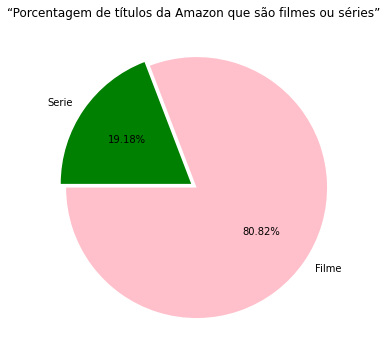

In [ ]:
plt.figure(figsize=(12,6))
plt.title("“Porcentagem de títulos da Amazon que são filmes ou séries”")
g = plt.pie(amazon_df.tipo.value_counts(),explode=(0.025,0.025), labels=amazon_df.tipo.value_counts().index, colors=['pink','green'],autopct='%1.2f%%', startangle=180)
plt.show()

In [ ]:
df2 = pd.read_csv('Amazon2021_tratado1.csv')

In [ ]:
df2.head()

,id,tipo,titulo,pais,data_adicionado,ano_lancamento,classificacao,duracao,genero
0,s1,Filme,A Grande Sedução,Canada,2021-03-30,2014,Nao avaliado,113 min,"Comedia, Drama"
1,s2,Filme,Cuide da boa noite,India,2021-03-30,2018,13+,110 min,"Drama, Internacional"
2,s3,Filme,Segredos da Decepção,Estados Unidos,2021-03-30,2017,Nao avaliado,74 min,"Acao, Drama, Suspense"
3,s4,Filme,Rosa: Mantendo-se Verdadeiro,Estados Unidos,2021-03-30,2014,Nao avaliado,69 min,Documentario
4,s5,Filme,Criador de Monstros,Reino Unido,2021-03-30,1989,Nao avaliado,45 min,"Drama, Fantasia"


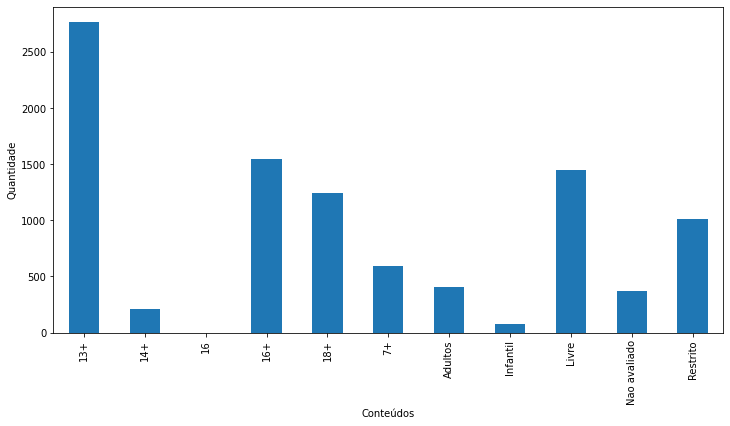

In [ ]:
df2.groupby(['classificacao']).size().plot.bar(figsize=(12,6),xlabel='Conteúdos',ylabel='Quantidade')

**Iniciando com** **PySpark**

In [ ]:
file_location = "/content/Amazon2021_tratado1.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
       
customSchema = StructType([
                              
                                StructField('id', StringType(),True),
                                StructField('tipo', StringType(),True),
                                StructField('titulo', StringType(),True),
                                StructField('pais', StringType(),True),
                                StructField('data_adicionado', StringType(),True),
                                StructField('ano_lancamento', IntegerType(),True),
                                StructField('classificacao', StringType(),True),
                                StructField('duracao', StringType(),True),
                                StructField('genero', StringType(),True)
                              
                              ])
df1 = spark.read.load(file_location, format="csv", header="true", sep=',', schema=customSchema)

df1.show(15)
df1.printSchema()

+---+-----+--------------------+--------------+---------------+--------------+-------------+-------+--------------------+
| id| tipo|              titulo|          pais|data_adicionado|ano_lancamento|classificacao|duracao|              genero|
+---+-----+--------------------+--------------+---------------+--------------+-------------+-------+--------------------+
| s1|Filme|    A Grande Sedução|        Canada|     2021-03-30|          2014| Nao avaliado|113 min|      Comedia, Drama|
| s2|Filme|  Cuide da boa noite|         India|     2021-03-30|          2018|          13+|110 min|Drama, Internacional|
| s3|Filme|Segredos da Decepção|Estados Unidos|     2021-03-30|          2017| Nao avaliado| 74 min|Acao, Drama, Susp...|
| s4|Filme|Rosa: Mantendo-se...|Estados Unidos|     2021-03-30|          2014| Nao avaliado| 69 min|        Documentario|
| s5|Filme| Criador de Monstros|   Reino Unido|     2021-03-30|          1989| Nao avaliado| 45 min|     Drama, Fantasia|
| s6|Filme|Living With D

In [ ]:
df1.show()


+---+-----+--------------------+--------------+---------------+--------------+-------------+-----------+--------------------+
| id| tipo|              titulo|          pais|data_adicionado|ano_lancamento|classificacao|    duracao|              genero|
+---+-----+--------------------+--------------+---------------+--------------+-------------+-----------+--------------------+
| s1|Filme|    A Grande Sedução|        Canada|     2021-03-30|          2014| Nao avaliado|    113 min|      Comedia, Drama|
| s2|Filme|  Cuide da boa noite|         India|     2021-03-30|          2018|          13+|    110 min|Drama, Internacional|
| s3|Filme|Segredos da Decepção|Estados Unidos|     2021-03-30|          2017| Nao avaliado|     74 min|Acao, Drama, Susp...|
| s4|Filme|Rosa: Mantendo-se...|Estados Unidos|     2021-03-30|          2014| Nao avaliado|     69 min|        Documentario|
| s5|Filme| Criador de Monstros|   Reino Unido|     2021-03-30|          1989| Nao avaliado|     45 min|     Drama, Fa

In [ ]:
df1.groupby(F.col("tipo")).count().show()

+-----+-----+
| tipo|count|
+-----+-----+
|Serie| 1854|
|Filme| 7814|
+-----+-----+



In [ ]:
df1.printSchema()

root
 |-- id: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- titulo: string (nullable = true)
 |-- pais: string (nullable = true)
 |-- data_adicionado: string (nullable = true)
 |-- ano_lancamento: integer (nullable = true)
 |-- classificacao: string (nullable = true)
 |-- duracao: string (nullable = true)
 |-- genero: string (nullable = true)



In [ ]:
df1.select(F.col("tipo"), F.col("titulo")).orderBy("tipo").show()

+-----+--------------------+
| tipo|              titulo|
+-----+--------------------+
|Filme|        Zis Boom Bah|
|Filme|Yoga for Abdomina...|
|Filme|            Zandalee|
|Filme|  Cuide da boa noite|
|Filme|Zambezi: Force of...|
|Filme|Rosa: Mantendo-se...|
|Filme|        Young Lovers|
|Filme|Living With Dinos...|
|Filme|Young Love (at th...|
|Filme|        Grease Live!|
|Filme|Young Love (at Bo...|
|Filme|      David's Mother|
|Filme|      You're Not You|
|Filme|           Take Care|
|Filme|     You, Me and Him|
|Filme|          Resilencia|
|Filme|Yoga with Sound M...|
|Filme|          Summer '03|
|Filme|Yoga to Harness Y...|
|Filme|Yoga to Ease Flig...|
+-----+--------------------+
only showing top 20 rows

